In [1]:
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm.notebook import tqdm

from custom_image_dataset import CustomImageDataset

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We use: {device}")

We use: cuda


# I. Datasets and Dataloaders

#### Load dataset csv files as pd dataframes and print statistics

In [4]:
path_chest_imagenome_customized = "/u/home/tanida/datasets/chest-imagenome-dataset-customized-full"

# reduce memory usage by only using necessary columns and selecting appropriate datatypes
usecols = ["mimic_image_file_path", "bbox_name", "x1", "y1", "x2", "y2", "is_abnormal"]
dtype = {"x1": "int16", "x2": "int16", "y1": "int16", "y2": "int16", "bbox_name": "category"} 

datasets_as_dfs = {dataset: os.path.join(path_chest_imagenome_customized, dataset) + ".csv" for dataset in ["train", "valid", "test"]}
datasets_as_dfs = {dataset: pd.read_csv(csv_file_path, usecols=usecols, dtype=dtype) for dataset, csv_file_path in datasets_as_dfs.items()}

In [ ]:
def print_num_samples_per_class(dataset, df):
    print(f"{dataset}:")
    for bbox_name, count in df["bbox_name"].value_counts().iteritems():
        print(f"\t{bbox_name}: {count}")
    print()

In [ ]:
# get number of samples per class for each dataset

# bboxes of anatomical regions are almost distributed equally in all datasets,
# only a slight imbalance because not every image has bboxes of all 36 anatomical regions
for dataset, df in datasets_as_dfs.items():
    print_num_samples_per_class(dataset, df)

In [5]:
# get number of samples for each dataset
total_num_samples = sum(len(df) for df in datasets_as_dfs.values())

for dataset, df in datasets_as_dfs.items():
    print(f"{dataset}: {len(df):,} images ({(len(df) / total_num_samples) * 100:.2f}%)")

train: 5,950,238 samples (70.00%)
valid: 855,467 samples (10.06%)
test: 1,694,389 samples (19.93%)


In [6]:
# if we don't want to train on the full train set (with 5,950,238 samples), we can specify the constant below to limit the train set

PERCENTAGE_OF_TRAIN_SET_TO_USE = 0.3
total_num_samples_train = len(datasets_as_dfs["train"])

new_num_samples_train = int(PERCENTAGE_OF_TRAIN_SET_TO_USE * total_num_samples_train)

datasets_as_dfs["train"] = datasets_as_dfs["train"][:new_num_samples_train]

print(f"train (new): {len(datasets_as_dfs['train']):,} samples")

train (new): 1,785,071 samples


#### Load datasets as Dataset objects

In [7]:
# constants for image transformations

# see compute_mean_std_dataset.py in src/dataset
mean = 0.471
std = 0.302

# pre-trained DenseNet121 model expects images to be of size 224x224
IMAGE_INPUT_SIZE = 224

In [8]:
# note: transforms are applied to the already cropped images (see __getitem__ method of CustomImageDataset class)!

# use albumentations for Compose and transforms
train_transforms = A.Compose([
    # we want the long edge of the image to be resized to IMAGE_INPUT_SIZE, and the short edge of the image to be padded to IMAGE_INPUT_SIZE on both sides,
    # such that the aspect ratio of the images are kept (i.e. a resized image of a lung is not distorted), 
    # while getting images of uniform size (IMAGE_INPUT_SIZE x IMAGE_INPUT_SIZE)
    A.LongestMaxSize(max_size=IMAGE_INPUT_SIZE, interpolation=cv2.INTER_AREA),  # resizes the longer edge to IMAGE_INPUT_SIZE while maintaining the aspect ratio (INTER_AREA works best for shrinking images)
    A.PadIfNeeded(min_height=IMAGE_INPUT_SIZE, min_width=IMAGE_INPUT_SIZE, border_mode=cv2.BORDER_CONSTANT),  # pads both sides of the shorter edge with 0's (black pixels)
    # A.HueSaturationValue(),
    # A.Affine(mode=cv2.BORDER_CONSTANT),
    # A.GaussianBlur(),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

# don't apply data augmentations to val and test set
val_test_transforms = A.Compose([
    A.LongestMaxSize(max_size=IMAGE_INPUT_SIZE, interpolation=cv2.INTER_AREA),
    A.PadIfNeeded(min_height=IMAGE_INPUT_SIZE, min_width=IMAGE_INPUT_SIZE, border_mode=cv2.BORDER_CONSTANT),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

In [9]:
train_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["train"], transforms=train_transforms)
val_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["valid"], transforms=val_test_transforms)
test_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["test"], transforms=val_test_transforms)

In [10]:
BATCH_SIZE = 64
NUM_WORKERS = 4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [11]:
next(iter(train_loader))

[ WARN:0@103.719] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/u/home/tanida/datasets/mimic-cxr-jpg/files/p12/p12971125/s59587232/0e3bc02f-eb944689-9240eb57-c274ad01-c2233012.jpg'): can't open/read file: check file path/integrity
[ WARN:0@104.934] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/u/home/tanida/datasets/mimic-cxr-jpg/files/p11/p11943612/s55906340/7c3ca826-2067e2c4-843f2d86-2139440b-87adab6a.jpg'): can't open/read file: check file path/integrity


error: Caught error in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/u/home/tanida/region-guided-chest-x-ray-report-generation/src/encoder/custom_image_dataset.py", line 34, in __getitem__
    cropped_image = self.transforms(image=cropped_image)["image"]
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/core/composition.py", line 210, in __call__
    data = t(force_apply=force_apply, **data)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/core/transforms_interface.py", line 97, in __call__
    return self.apply_with_params(params, **kwargs)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/core/transforms_interface.py", line 112, in apply_with_params
    res[key] = target_function(arg, **dict(params, **target_dependencies))
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/geometric/resize.py", line 83, in apply
    return F.longest_max_size(img, max_size=max_size, interpolation=interpolation)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/functional.py", line 70, in wrapped_function
    result = func(img, *args, **kwargs)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/geometric/functional.py", line 324, in longest_max_size
    return _func_max_size(img, max_size, interpolation, max)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/geometric/functional.py", line 318, in _func_max_size
    img = resize(img, height=new_height, width=new_width, interpolation=interpolation)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/functional.py", line 70, in wrapped_function
    result = func(img, *args, **kwargs)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/geometric/functional.py", line 277, in resize
    return resize_fn(img)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/functional.py", line 189, in __process_fn
    img = process_fn(img, **kwargs)
cv2.error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



[ WARN:0@106.682] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/u/home/tanida/datasets/mimic-cxr-jpg/files/p12/p12948059/s52135029/af1733a6-bb52ce5b-d8484fad-1bd8a8fc-dd0ce8c0.jpg'): can't open/read file: check file path/integrity
[ WARN:0@108.908] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/u/home/tanida/datasets/mimic-cxr-jpg/files/p11/p11942799/s51040959/5cf6af6c-30d7df66-37aabf84-d61300d0-e58b55cc.jpg'): can't open/read file: check file path/integrity
[ WARN:0@108.908] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/u/home/tanida/datasets/mimic-cxr-jpg/files/p11/p11928388/s54015954/29e737e9-2c7323d4-807b01a0-ea41cd59-3612fa0a.jpg'): can't open/read file: check file path/integrity


In [14]:
from time import time
import multiprocessing as mp
for num_workers in range(2, mp.cpu_count(), 2):  
    train_loader = DataLoader(train_dataset,shuffle=True,num_workers=num_workers,batch_size=64,pin_memory=True)
    start = time()
    for epoch in range(1, 3):
        for data in train_loader:
            continue
    end = time()
    print(f"Finish with:{end - start} second, num_workers={num_workers}")

error: Caught error in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/u/home/tanida/region-guided-chest-x-ray-report-generation/src/encoder/custom_image_dataset.py", line 34, in __getitem__
    cropped_image = self.transforms(image=cropped_image)["image"]
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/core/composition.py", line 210, in __call__
    data = t(force_apply=force_apply, **data)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/core/transforms_interface.py", line 97, in __call__
    return self.apply_with_params(params, **kwargs)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/core/transforms_interface.py", line 112, in apply_with_params
    res[key] = target_function(arg, **dict(params, **target_dependencies))
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/geometric/resize.py", line 83, in apply
    return F.longest_max_size(img, max_size=max_size, interpolation=interpolation)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/functional.py", line 70, in wrapped_function
    result = func(img, *args, **kwargs)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/geometric/functional.py", line 324, in longest_max_size
    return _func_max_size(img, max_size, interpolation, max)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/geometric/functional.py", line 318, in _func_max_size
    img = resize(img, height=new_height, width=new_width, interpolation=interpolation)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/functional.py", line 70, in wrapped_function
    result = func(img, *args, **kwargs)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/geometric/functional.py", line 277, in resize
    return resize_fn(img)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/functional.py", line 189, in __process_fn
    img = process_fn(img, **kwargs)
cv2.error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



[ WARN:0@107.334] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/u/home/tanida/datasets/mimic-cxr-jpg/files/p11/p11996157/s54968421/31c32ffd-aac9a015-868cb1e2-86f5a335-ac3d672f.jpg'): can't open/read file: check file path/integrity
[ WARN:0@108.570] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/u/home/tanida/datasets/mimic-cxr-jpg/files/p11/p11914297/s54901424/d0539208-cc42e490-6a63a524-cfa102bd-675a07c2.jpg'): can't open/read file: check file path/integrity


In [ ]:
train_transforms = A.Compose([
    # we want the long edge of the image to be resized to IMAGE_INPUT_SIZE, and the short edge of the image to be padded to IMAGE_INPUT_SIZE on both sides,
    # such that the aspect ratio of the images are kept (i.e. a resized image of a lung is not distorted), 
    # while getting images of uniform size (IMAGE_INPUT_SIZE x IMAGE_INPUT_SIZE)

    # the custom class CustomResize resizes the longer edge to IMAGE_INPUT_SIZE while maintaining the aspect ratio
    A.LongestMaxSize(max_size=224, interpolation=cv2.INTER_AREA),
    A.PadIfNeeded(min_height=224, min_width=224, border_mode=cv2.BORDER_CONSTANT)
])

In [5]:
from PIL import Image
import cv2

(723, 818, 3)


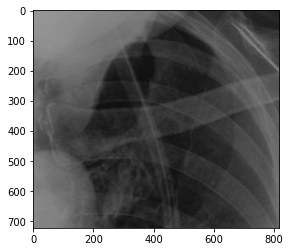

In [6]:
image_path = "/u/home/tanida/datasets/mimic-cxr-jpg/files/p10/p10001401/s50225296/0009a9fb-eb905e90-824cad7c-16d40468-007f0038.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
np_cropped_image = image[409:1132, 1364:2182]  # img[Y:Y+H, X:X+W]
print(np_cropped_image.shape)
plt.imshow(np_cropped_image)

In [ ]:
image_path = "/u/home/tanida/datasets/mimic-cxr-jpg/files/p10/p10001401/s50225296/0009a9fb-eb905e90-824cad7c-16d40468-007f0038.jpg"
image = Image.open(image_path)

bbox_coords = [245, 1800, 2264, 3042]
cropped_image = image.crop(box=bbox_coords)

print(type(cropped_image))
print(cropped_image.size)
display(cropped_image)

In [67]:
0.301 * 255

76.755

In [ ]:
new_resized_cropped_image = train_transforms(image=np_cropped_image)["image"]
print(new_resized_cropped_image.shape)
plt.imshow(new_resized_cropped_image)

In [ ]:
new_resized_cropped_image == resized_cropped_image

In [ ]:
resized_cropped_image = transforms.functional.resize(cropped_image, size=223, max_size=224)
print(resized_cropped_image)
display(resized_cropped_image)

In [14]:
from torchvision.transforms.functional import pil_to_tensor

In [63]:
img_path = "/u/home/tanida/datasets/mimic-cxr-jpg/files/p13/p13820640/s54192530/e9b7f879-0aa0b42d-5b1b752d-69ae71ac-3d0da7af.jpg"
cv2_img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
mean = cv2_img.mean()
print(mean)
last_mean_values = [3.5, 123.3, 234.3]
print(abs(mean - last_mean_values) <= 1000)
print(np.all([abs(mean - last_mean_values) <= 1000, abs(mean - last_mean_values) <= 10]))


128.9662323987866
[ True  True  True]
False


In [69]:
import multiprocessing as mp
mp.cpu_count()

48

In [ ]:
# specify path to folder where model weights should be saved
model_save_path = "/u/home/tanida/weights/encoder"